In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
# Read in the data
cal = pd.read_csv('calendar.csv')
stv = pd.read_csv('sales_train_validation.csv')
ss = pd.read_csv('sample_submission.csv')
sellp = pd.read_csv('sell_prices.csv')

In [3]:
# objective is to forecast sales for 28 days
ss.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
# we are given historic sales data in the sales_train_validation dataset.
stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [3]:
# lets change the data into a more usable format
# we can melt the dataset so that the daily sales will be rows
stv = pd.melt(stv, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')

In [31]:
stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [32]:
stv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 8 columns):
id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
state_id    object
day         object
demand      int64
dtypes: int64(1), object(7)
memory usage: 3.5+ GB


In [33]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [5]:
# just using certain columns from the calender dataset for now
# and combining it with our sales data
cal_cols = list(cal.columns[:7])
stv = stv.merge(cal[cal_cols], how='left',left_on = 'day', right_on = 'd')

In [9]:
stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,date,wm_yr_wk,weekday,wday,month,year,d
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1


In [25]:
# seeing if we have data on the same number of items at each store
stv.groupby(['store_id']).agg({'id':'nunique'})

,id
store_id,
CA_1,3049
CA_2,3049
CA_3,3049
CA_4,3049
TX_1,3049
TX_2,3049
TX_3,3049
WI_1,3049
WI_2,3049


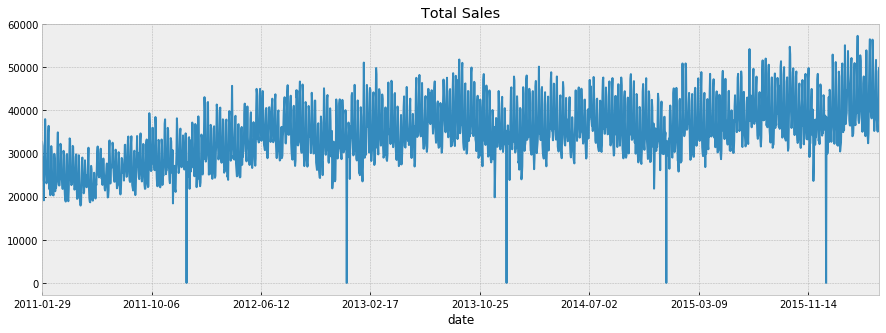

In [26]:
stv.groupby('date').sum()['demand'].plot(figsize=(15, 5),
          title='Total Sales',
          color=next(color_cycle))
plt.show()

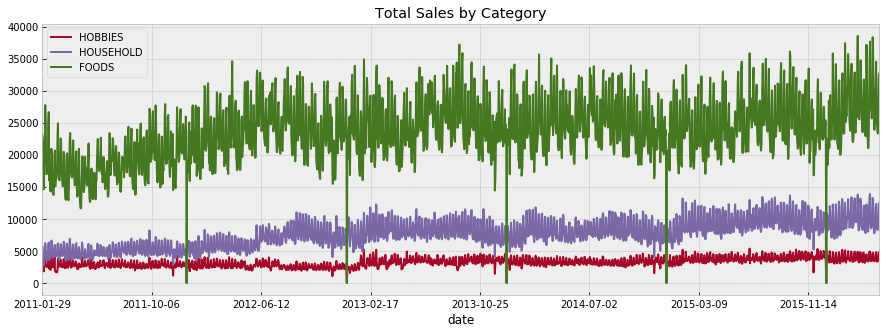

In [27]:
for cat in stv.cat_id.unique():
    stv.loc[stv['cat_id'] == cat].groupby('date').sum()['demand'].plot(figsize=(15, 5),
          title='Total Sales by Category',
          color=next(color_cycle))
plt.legend(stv['cat_id'].unique())
plt.show()

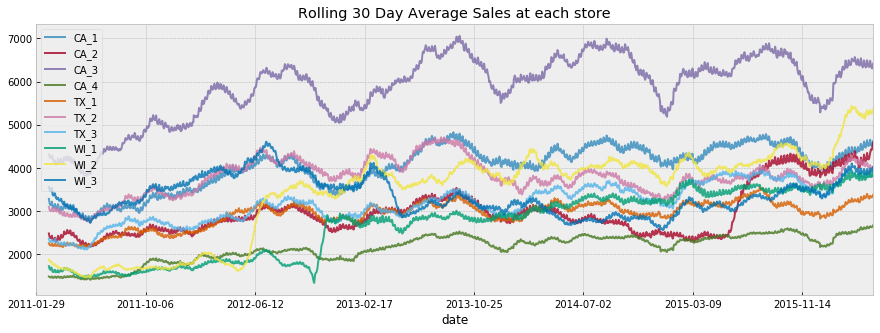

In [77]:
store_list = stv['store_id'].unique()
for store in store_list:
    stv[stv['store_id'] == store].groupby('date').sum().rolling(30).mean()['demand'].plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 30 Day Average Sales at each store')
plt.legend(store_list)
plt.show()

In [45]:
# finding the top selling item in each category
for cat in stv.cat_id.unique():
    print(stv[stv['cat_id'] == cat].groupby('id').sum().idxmax())

demand    HOBBIES_1_234_CA_3_validation
dtype: object
demand    HOUSEHOLD_1_118_CA_3_validation
dtype: object
demand    FOODS_3_090_CA_3_validation
dtype: object


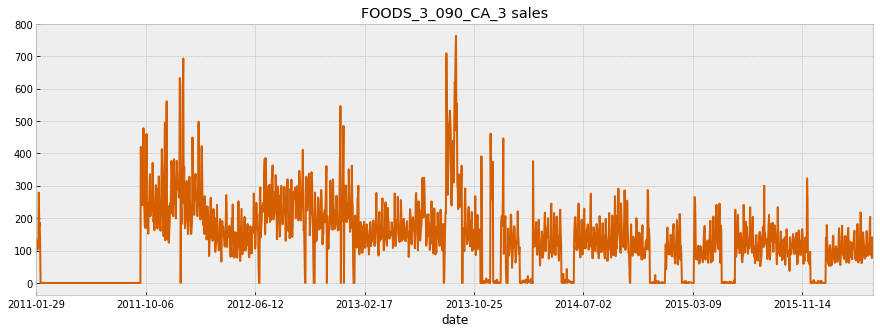

In [78]:
# create visualization for the top selling items
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'].set_index('date')['demand'].plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales',
          color=next(color_cycle))
plt.show()

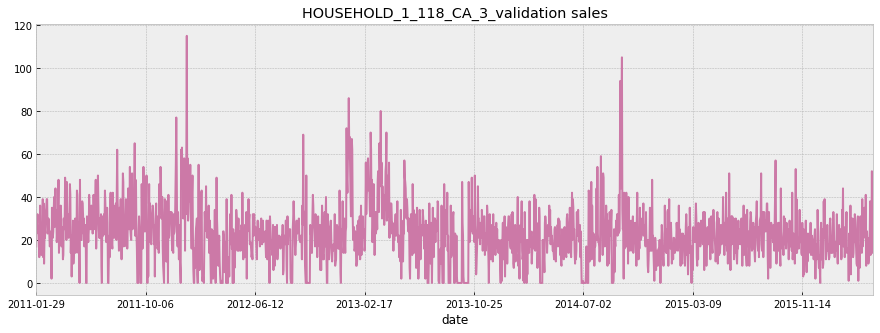

In [79]:
stv.loc[stv['id'] == 'HOUSEHOLD_1_118_CA_3_validation'].set_index('date')['demand'].plot(figsize=(15, 5),
          title='HOUSEHOLD_1_118_CA_3_validation sales',
          color=next(color_cycle))
plt.show()

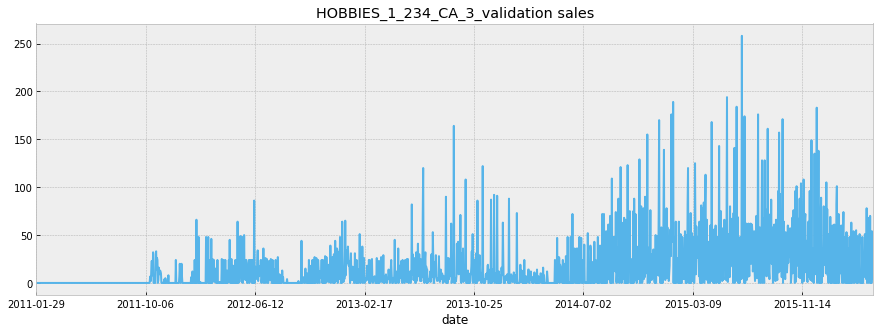

In [80]:
stv.loc[stv['id'] == 'HOBBIES_1_234_CA_3_validation'].set_index('date')['demand'].plot(figsize=(15, 5),
          title='HOBBIES_1_234_CA_3_validation sales',
          color=next(color_cycle))
plt.show()

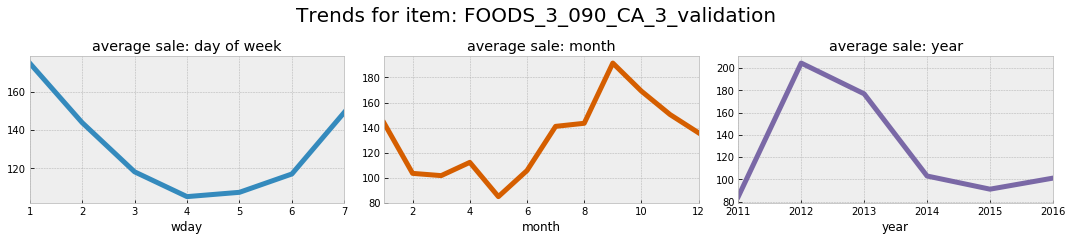

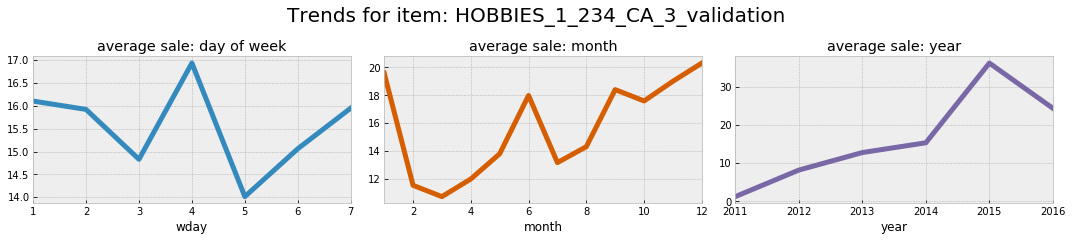

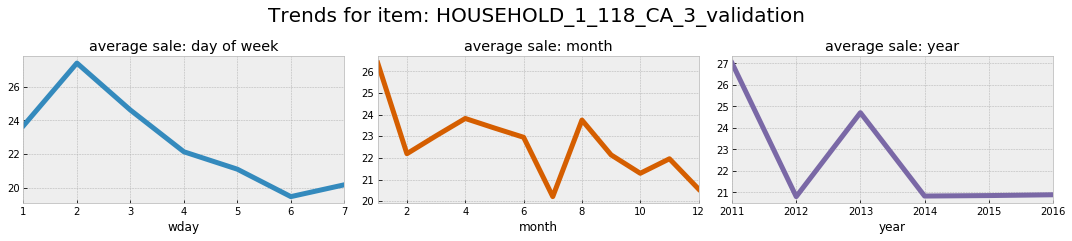

In [84]:
top3 = ['FOODS_3_090_CA_3_validation','HOBBIES_1_234_CA_3_validation','HOUSEHOLD_1_118_CA_3_validation']
for item in top3:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    stv[stv['id'] == item].groupby('wday').mean()['demand'] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    stv[stv['id'] == item].groupby('month').mean()['demand'] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[4],
              ax=ax2)
    stv[stv['id'] == item].groupby('year').mean()['demand'] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],
              ax=ax3)
    fig.suptitle(f'Trends for item: {item}',
                 size=20,
                 y=1.1)
    plt.tight_layout()
    plt.show()

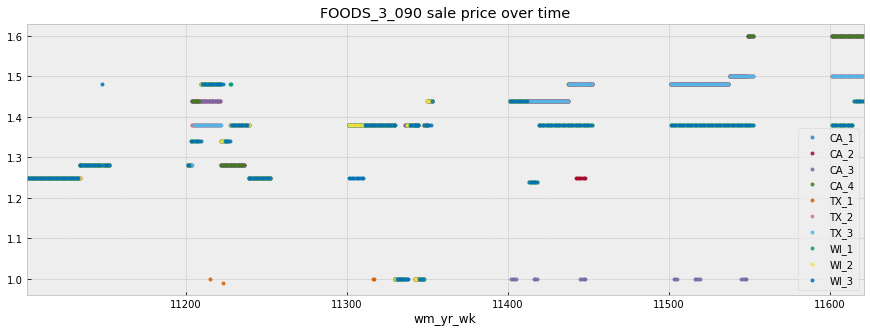

In [4]:
store_list = sellp['store_id'].unique()
for store in store_list:
    sellp[(sellp['store_id'] == store) & (sellp['item_id'] == 'FOODS_3_090')].groupby('wm_yr_wk').mean()['sell_price'] \
    .plot(figsize=(15, 5),
          alpha=0.8,
          title='FOODS_3_090 sale price over time', 
          style = ' .')
plt.legend(store_list)
plt.show()